In [25]:
! pip install -q mplfinance

##Import libraries

In [26]:
import os
from pathlib import Path
import pandas as pd
import sklearn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    r2_score,
    mean_absolute_percentage_error
)

### Defin indexes





In [27]:
def compute_rsi(prices, period=14):
    """
    Compute the Relative Strength Index (RSI) for a series of prices.
    Returns a 1D numpy array of RSI values. The first (period-1) values will be NaN.
    """
    prices = np.array(prices)
    deltas = np.diff(prices)
    seed = deltas[:period]
    up = seed[seed >= 0].sum() / period
    down = -seed[seed < 0].sum() / period
    rs = up / down if down != 0 else 0
    rsi = np.zeros_like(prices)
    rsi[:period] = np.nan
    rsi[period - 1] = 100. - 100. / (1. + rs)
    for i in range(period, len(prices)):
        delta = deltas[i - 1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta
        up = (up * (period - 1) + upval) / period
        down = (down * (period - 1) + downval) / period
        rs = up / down if down != 0 else 0
        rsi[i] = 100. - 100. / (1. + rs)
    return rsi

def compute_macd(prices, fast=12, slow=26, signal=9):
    """
    Compute the MACD (Moving Average Convergence Divergence) for a series of prices.
    Returns a tuple of three 1D numpy arrays: (macd, signal_line, histogram).
    """
    prices = pd.Series(np.array(prices).flatten())
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    histogram = macd - signal_line
    return macd.values, signal_line.values, histogram.values

In [28]:
# Check if a CUDA-compatible GPU is available. If yes, use it; otherwise, fall back to the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

csv_file_path = '/content/BTC_USD.csv'

# Extract base name without extension for naming
csv_base = Path(csv_file_path).stem

# Define paths for saving the best model and its metrics
model_history_dir = Path('model_history')
result_history_dir = Path('result_history')

os.makedirs(model_history_dir, exist_ok=True)
os.makedirs(result_history_dir, exist_ok=True)

best_model_filename = f"{csv_base}_best_model.pt"
best_model_path = model_history_dir / best_model_filename
metrics_path = result_history_dir / f"{csv_base}_metrics.txt"

forecast_history = 24  # Number of past time steps to use for input sequences.
forecast_horizon = 1  # Number of future time steps to predict (e.g., 0 means predicting the next step immediately).

batch_size = 64  # Number of samples in each mini-batch
max_iterations = 100
model_name = 'xLstm'

best_mse = float('inf')

###Preprocess

In [29]:
# Load Data
try:
  df_raw = pd.read_csv(csv_file_path)
  print("CSV file loaded successfully.")
except Exception as e:
  print(f"Error reading CSV file: {e}")

df_raw.head(10)

CSV file loaded successfully.


,Date,Price,Open,High,Low,Vol.,Change %
0,01/26/2025,105000.0,104700.0,105440.0,104510.0,0.11K,0.29%
1,01/25/2025,104700.0,104800.0,105260.0,104100.0,0.14K,-0.10%
2,01/24/2025,104800.0,103930.0,107030.0,102720.0,0.52K,0.84%
3,01/23/2025,103930.0,103680.0,106780.0,101260.0,1.70K,0.24%
4,01/22/2025,103680.0,106150.0,106290.0,103400.0,0.51K,-2.33%
5,01/21/2025,106150.0,102170.0,107360.0,100140.0,1.12K,3.90%
6,01/20/2025,102170.0,101360.0,109410.0,99634.0,2.92K,0.80%
7,01/19/2025,101360.0,104490.0,106370.0,99675.0,1.04K,-3.00%
8,01/18/2025,104490.0,104040.0,104950.0,102200.0,0.54K,0.43%
9,01/17/2025,104040.0,100040.0,105800.0,100000.0,1.26K,4.00%


In [30]:
# Preprocess data
datetime_col = "Date"
freq = '1D'
columns = ['Price']
method = 'ffill'
value = 0


# Define a data preprocessing pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    # Step 1: Drop duplicate rows based on the datetime column
    ('drop_duplicates', sklearn.preprocessing.FunctionTransformer(lambda df: df.drop_duplicates(subset=datetime_col))),

    # Step 2: Fill missing values in the dataset
    ('fill_missing', sklearn.preprocessing.FunctionTransformer(
        lambda df: df.fillna(method=method).fillna(value=value)  # Fill missing values using a specified method and value
    ))
])

# Apply the pipeline to the raw data
df = preproc_pipe.fit_transform(df_raw)

# Convert the datetime column to a standard datetime format
df[datetime_col] = pd.to_datetime(df[datetime_col])

# Sort the data by the datetime column in ascending order
df = df.sort_values(by=datetime_col)



<ipython-input-30-9782ae18296c>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda df: df.fillna(method=method).fillna(value=value)  # Fill missing values using a specified method and value


In [31]:
# Define the proportions for test and validation sets
test_size = 0.05  # Fraction of the data to be used as the test set
valid_size = 0.05  # Fraction of the data to be used as the validation set

# Calculate the total number of samples in the dataset
total_size = len(df)  # The total number of rows in the DataFrame

# Calculate the number of samples for the test set
test_split = int(total_size * test_size)  # Convert the test size fraction to the actual count

# Calculate the number of samples for the validation set
valid_split = int(total_size * valid_size)  # Convert the validation size fraction to the actual count

# Calculate the end index of the training set (exclusive)
train_end = total_size - test_split - valid_split  # Determine where the training set ends

# Calculate the end index of the validation set (exclusive)
valid_end = total_size - test_split  # Determine where the validation set ends

# Split the data into training, validation, and test sets using indices
train_df = df.iloc[:train_end]  # Select rows for the training set
valid_df = df.iloc[train_end:valid_end]  # Select rows for the validation set
test_df = df.iloc[valid_end:]  # Select rows for the test set

# Print the sizes of each split for verification
print(f"Data split into train ({len(train_df)}), validation ({len(valid_df)}), and test ({len(test_df)}) sets.")


Data split into train (3311), validation (183), and test (183) sets.


In [32]:
# Define the columns to be scaled
scale_columns = ['Price']  # Specify the column(s) to scale, in this case 'Price'

# Initialize the MinMaxScaler with a feature range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler using the training data
scaler.fit(train_df[scale_columns])  # Calculate the min and max values from the training set for scaling

# Transform the training data using the fitted scaler
train_scaled = scaler.transform(train_df[scale_columns])  # Scale the 'Price' column in the training set

# Transform the validation data using the same scaler
valid_scaled = scaler.transform(valid_df[scale_columns])  # Apply the same scaling to the validation set

# Transform the test data using the same scaler
test_scaled = scaler.transform(test_df[scale_columns])  # Apply the same scaling to the test set

# Print a message indicating that the scaling is complete
print("Data scaling completed.")


Data scaling completed.


In [33]:

# Function to create input-output sequences for training/testing
def create_sequences(data, seq_length, horizon):
    """
    Generate sequences of input features (X) and corresponding target values (y).

    Args:
        data: The scaled dataset to create sequences from.
        seq_length: Number of past time steps to use as input.
        horizon: Number of future time steps to predict.


    Returns:
        X (Tensor): Tensor of input sequences.
        y (Tensor): Tensor of target values corresponding to the sequences.
    """
    X, y = [], []  # Initialize empty lists for input (X) and output (y)

    # Iterate over the dataset to create sequences
    for i in range(len(data) - seq_length - horizon + 1):  # Ensure valid indices for sequences
        X.append(data[i:(i + seq_length)])  # Extract 'seq_length' past time steps
        y.append(data[i + seq_length + horizon - 1])  # Extract the target value at the specified horizon
    return torch.Tensor(X), torch.Tensor(y)  # Convert lists to PyTorch tensors for use in models

# Create input and output sequences for the training set
trainX, trainY = create_sequences(train_scaled, forecast_history, forecast_horizon)

# Create input and output sequences for the validation set
validX, validY = create_sequences(valid_scaled, forecast_history, forecast_horizon)

# Create input and output sequences for the test set
testX, testY = create_sequences(test_scaled, forecast_history, forecast_horizon)

print('Data sequence is created.')

Data sequence is created.


In [34]:
# Create datasets for training, validation, and testing
train_dataset = TensorDataset(trainX, trainY)  # Pair input sequences (trainX) with corresponding targets (trainY)
valid_dataset = TensorDataset(validX, validY)  # Pair validation inputs (validX) with targets (validY)
test_dataset = TensorDataset(testX, testY)  # Pair test inputs (testX) with targets (testY)

# Create data loaders for efficient batching during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Load training data with shuffling for randomized batches
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)  # Load validation data without shuffling for consistent order
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Load test data without shuffling for consistent order


###Define model

In [35]:
from xLSTM import xLSTM

In [36]:
# Define model parameters
input_size = 1
head_size = 32
layers = ['s', 'm', 's']  # Example layer configuration
num_heads = 2


# Create the mLSTM model
model = xLSTM(input_size, head_size, num_heads, layers, batch_first=True).to(device)
# - `batch_first=True`: Input tensors should have shape (batch_size, sequence_length, input_size).
# - `.to(device)`: Move the model to the specified device (e.g., GPU or CPU).


# Define the loss function to measure the model's error
criterion = torch.nn.MSELoss()
# - `MSELoss`: Mean Squared Error loss is suitable for regression tasks, where the goal is to minimize the difference between predicted and actual values.


# Define the optimizer to update model parameters during training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# - Uses the Adam optimizer, which adapts the learning rate for each parameter.
# - `lr=0.001`: Sets the learning rate for the optimizer.


###Train

In [37]:
def log_print(*args, **kwargs):
    with open(metrics_path, 'a') as metrics_file:
        msg = ' '.join(map(str, args))
        print(msg)
        metrics_file.write(msg + '\n')

In [38]:
log_print(f"Model Name: {model_name}")
log_print(f"Sequence Length (Forecast History): {forecast_history}")
log_print(f"Forecast Horizon: {forecast_horizon}")
log_print(f"Training Started at: {pd.Timestamp.now()}")
for iteration in range(max_iterations):
            log_print(f"\nStarting training iteration {iteration + 1}/{max_iterations}")

            model.train()
            epoch_loss = 0
            for inputs, targets in tqdm(train_loader, desc=f"Training Iteration {iteration + 1}"):
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs, _ = model(inputs)
                outputs = outputs[:, -1, :]  # Take the last output
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_epoch_loss = epoch_loss / len(train_loader)
            log_print(f"Iteration {iteration + 1}: Average Training Loss: {avg_epoch_loss:.6f}")

            # Validate the model
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, targets in valid_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs, _ = model(inputs)
                    outputs = outputs[:, -1, :]
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(valid_loader)
            log_print(f"Iteration {iteration + 1}: Average Validation Loss: {avg_val_loss:.6f}")

            if avg_val_loss < best_mse:
                best_mse = avg_val_loss
                torch.save(model.state_dict(), best_model_path)
                log_print(f"New best model saved at '{best_model_path}' with Validation MSE {best_mse:.6f}")

Model Name: xLstm
Sequence Length (Forecast History): 24
Forecast Horizon: 1
Training Started at: 2025-05-20 12:48:56.989476

Starting training iteration 1/100


Training Iteration 1: 100%|██████████| 52/52 [00:38<00:00,  1.36it/s]


Iteration 1: Average Training Loss: 0.004402
Iteration 1: Average Validation Loss: 0.000760
New best model saved at 'model_history/BTC_USD_best_model.pt' with Validation MSE 0.000760

Starting training iteration 2/100


Training Iteration 2: 100%|██████████| 52/52 [00:21<00:00,  2.41it/s]


Iteration 2: Average Training Loss: 0.000151
Iteration 2: Average Validation Loss: 0.000752
New best model saved at 'model_history/BTC_USD_best_model.pt' with Validation MSE 0.000752

Starting training iteration 3/100


Training Iteration 3: 100%|██████████| 52/52 [00:23<00:00,  2.22it/s]


Iteration 3: Average Training Loss: 0.000161
Iteration 3: Average Validation Loss: 0.000727
New best model saved at 'model_history/BTC_USD_best_model.pt' with Validation MSE 0.000727

Starting training iteration 4/100


Training Iteration 4: 100%|██████████| 52/52 [00:23<00:00,  2.24it/s]


Iteration 4: Average Training Loss: 0.000154
Iteration 4: Average Validation Loss: 0.000753

Starting training iteration 5/100


Training Iteration 5: 100%|██████████| 52/52 [00:23<00:00,  2.18it/s]


Iteration 5: Average Training Loss: 0.000156
Iteration 5: Average Validation Loss: 0.000727

Starting training iteration 6/100


Training Iteration 6: 100%|██████████| 52/52 [00:23<00:00,  2.22it/s]


Iteration 6: Average Training Loss: 0.000153
Iteration 6: Average Validation Loss: 0.000752

Starting training iteration 7/100


Training Iteration 7: 100%|██████████| 52/52 [00:23<00:00,  2.21it/s]


Iteration 7: Average Training Loss: 0.000159
Iteration 7: Average Validation Loss: 0.000831

Starting training iteration 8/100


Training Iteration 8: 100%|██████████| 52/52 [00:22<00:00,  2.26it/s]


Iteration 8: Average Training Loss: 0.000156
Iteration 8: Average Validation Loss: 0.000704
New best model saved at 'model_history/BTC_USD_best_model.pt' with Validation MSE 0.000704

Starting training iteration 9/100


Training Iteration 9: 100%|██████████| 52/52 [00:23<00:00,  2.25it/s]


Iteration 9: Average Training Loss: 0.000175
Iteration 9: Average Validation Loss: 0.000716

Starting training iteration 10/100


Training Iteration 10: 100%|██████████| 52/52 [00:23<00:00,  2.21it/s]


Iteration 10: Average Training Loss: 0.000152
Iteration 10: Average Validation Loss: 0.000705

Starting training iteration 11/100


Training Iteration 11: 100%|██████████| 52/52 [00:22<00:00,  2.34it/s]


Iteration 11: Average Training Loss: 0.000154
Iteration 11: Average Validation Loss: 0.000758

Starting training iteration 12/100


Training Iteration 12: 100%|██████████| 52/52 [00:23<00:00,  2.19it/s]


Iteration 12: Average Training Loss: 0.000157
Iteration 12: Average Validation Loss: 0.000719

Starting training iteration 13/100


Training Iteration 13: 100%|██████████| 52/52 [00:23<00:00,  2.19it/s]


Iteration 13: Average Training Loss: 0.000181
Iteration 13: Average Validation Loss: 0.000704
New best model saved at 'model_history/BTC_USD_best_model.pt' with Validation MSE 0.000704

Starting training iteration 14/100


Training Iteration 14: 100%|██████████| 52/52 [00:22<00:00,  2.29it/s]


Iteration 14: Average Training Loss: 0.000159
Iteration 14: Average Validation Loss: 0.000744

Starting training iteration 15/100


Training Iteration 15: 100%|██████████| 52/52 [00:23<00:00,  2.25it/s]


Iteration 15: Average Training Loss: 0.000164
Iteration 15: Average Validation Loss: 0.000898

Starting training iteration 16/100


Training Iteration 16: 100%|██████████| 52/52 [00:23<00:00,  2.26it/s]


Iteration 16: Average Training Loss: 0.000175
Iteration 16: Average Validation Loss: 0.000707

Starting training iteration 17/100


Training Iteration 17: 100%|██████████| 52/52 [00:22<00:00,  2.35it/s]


Iteration 17: Average Training Loss: 0.000160
Iteration 17: Average Validation Loss: 0.000709

Starting training iteration 18/100


Training Iteration 18: 100%|██████████| 52/52 [00:23<00:00,  2.24it/s]


Iteration 18: Average Training Loss: 0.000163
Iteration 18: Average Validation Loss: 0.000736

Starting training iteration 19/100


Training Iteration 19: 100%|██████████| 52/52 [00:22<00:00,  2.27it/s]


Iteration 19: Average Training Loss: 0.000178
Iteration 19: Average Validation Loss: 0.000871

Starting training iteration 20/100


Training Iteration 20: 100%|██████████| 52/52 [00:21<00:00,  2.38it/s]


Iteration 20: Average Training Loss: 0.000189
Iteration 20: Average Validation Loss: 0.000798

Starting training iteration 21/100


Training Iteration 21: 100%|██████████| 52/52 [00:25<00:00,  2.06it/s]


Iteration 21: Average Training Loss: 0.000166
Iteration 21: Average Validation Loss: 0.000710

Starting training iteration 22/100


Training Iteration 22: 100%|██████████| 52/52 [00:23<00:00,  2.21it/s]


Iteration 22: Average Training Loss: 0.000156
Iteration 22: Average Validation Loss: 0.000785

Starting training iteration 23/100


Training Iteration 23: 100%|██████████| 52/52 [00:22<00:00,  2.36it/s]


Iteration 23: Average Training Loss: 0.000189
Iteration 23: Average Validation Loss: 0.000705

Starting training iteration 24/100


Training Iteration 24: 100%|██████████| 52/52 [00:23<00:00,  2.23it/s]


Iteration 24: Average Training Loss: 0.000386
Iteration 24: Average Validation Loss: 0.001686

Starting training iteration 25/100


Training Iteration 25: 100%|██████████| 52/52 [00:24<00:00,  2.08it/s]


Iteration 25: Average Training Loss: 0.000318
Iteration 25: Average Validation Loss: 0.001207

Starting training iteration 26/100


Training Iteration 26: 100%|██████████| 52/52 [00:23<00:00,  2.23it/s]


Iteration 26: Average Training Loss: 0.000240
Iteration 26: Average Validation Loss: 0.000763

Starting training iteration 27/100


Training Iteration 27: 100%|██████████| 52/52 [00:22<00:00,  2.27it/s]


Iteration 27: Average Training Loss: 0.000177
Iteration 27: Average Validation Loss: 0.000717

Starting training iteration 28/100


Training Iteration 28: 100%|██████████| 52/52 [00:22<00:00,  2.30it/s]


Iteration 28: Average Training Loss: 0.000153
Iteration 28: Average Validation Loss: 0.000715

Starting training iteration 29/100


Training Iteration 29: 100%|██████████| 52/52 [00:31<00:00,  1.65it/s]


Iteration 29: Average Training Loss: 0.000157
Iteration 29: Average Validation Loss: 0.000716

Starting training iteration 30/100


Training Iteration 30: 100%|██████████| 52/52 [00:21<00:00,  2.37it/s]


Iteration 30: Average Training Loss: 0.000152
Iteration 30: Average Validation Loss: 0.000735

Starting training iteration 31/100


Training Iteration 31: 100%|██████████| 52/52 [00:23<00:00,  2.23it/s]


Iteration 31: Average Training Loss: 0.000148
Iteration 31: Average Validation Loss: 0.000741

Starting training iteration 32/100


Training Iteration 32: 100%|██████████| 52/52 [00:23<00:00,  2.22it/s]


Iteration 32: Average Training Loss: 0.000154
Iteration 32: Average Validation Loss: 0.000720

Starting training iteration 33/100


Training Iteration 33: 100%|██████████| 52/52 [00:23<00:00,  2.24it/s]


Iteration 33: Average Training Loss: 0.000158
Iteration 33: Average Validation Loss: 0.000707

Starting training iteration 34/100


Training Iteration 34: 100%|██████████| 52/52 [00:22<00:00,  2.28it/s]


Iteration 34: Average Training Loss: 0.000159
Iteration 34: Average Validation Loss: 0.000739

Starting training iteration 35/100


Training Iteration 35: 100%|██████████| 52/52 [00:23<00:00,  2.21it/s]


Iteration 35: Average Training Loss: 0.000163
Iteration 35: Average Validation Loss: 0.000716

Starting training iteration 36/100


Training Iteration 36: 100%|██████████| 52/52 [00:22<00:00,  2.35it/s]


Iteration 36: Average Training Loss: 0.000158
Iteration 36: Average Validation Loss: 0.000734

Starting training iteration 37/100


Training Iteration 37: 100%|██████████| 52/52 [00:23<00:00,  2.20it/s]


Iteration 37: Average Training Loss: 0.000157
Iteration 37: Average Validation Loss: 0.000921

Starting training iteration 38/100


Training Iteration 38: 100%|██████████| 52/52 [00:23<00:00,  2.22it/s]


Iteration 38: Average Training Loss: 0.000169
Iteration 38: Average Validation Loss: 0.000720

Starting training iteration 39/100


Training Iteration 39: 100%|██████████| 52/52 [00:22<00:00,  2.34it/s]


Iteration 39: Average Training Loss: 0.000156
Iteration 39: Average Validation Loss: 0.000719

Starting training iteration 40/100


Training Iteration 40: 100%|██████████| 52/52 [00:23<00:00,  2.23it/s]


Iteration 40: Average Training Loss: 0.000157
Iteration 40: Average Validation Loss: 0.000715

Starting training iteration 41/100


Training Iteration 41: 100%|██████████| 52/52 [00:23<00:00,  2.24it/s]


Iteration 41: Average Training Loss: 0.000150
Iteration 41: Average Validation Loss: 0.000715

Starting training iteration 42/100


Training Iteration 42: 100%|██████████| 52/52 [00:22<00:00,  2.31it/s]


Iteration 42: Average Training Loss: 0.000162
Iteration 42: Average Validation Loss: 0.000798

Starting training iteration 43/100


Training Iteration 43: 100%|██████████| 52/52 [00:23<00:00,  2.23it/s]


Iteration 43: Average Training Loss: 0.000181
Iteration 43: Average Validation Loss: 0.000761

Starting training iteration 44/100


Training Iteration 44: 100%|██████████| 52/52 [00:22<00:00,  2.31it/s]


Iteration 44: Average Training Loss: 0.000355
Iteration 44: Average Validation Loss: 0.000777

Starting training iteration 45/100


Training Iteration 45: 100%|██████████| 52/52 [00:22<00:00,  2.31it/s]


Iteration 45: Average Training Loss: 0.000174
Iteration 45: Average Validation Loss: 0.000713

Starting training iteration 46/100


Training Iteration 46: 100%|██████████| 52/52 [00:23<00:00,  2.25it/s]


Iteration 46: Average Training Loss: 0.000157
Iteration 46: Average Validation Loss: 0.000741

Starting training iteration 47/100


Training Iteration 47: 100%|██████████| 52/52 [00:22<00:00,  2.30it/s]


Iteration 47: Average Training Loss: 0.000158
Iteration 47: Average Validation Loss: 0.000732

Starting training iteration 48/100


Training Iteration 48: 100%|██████████| 52/52 [00:22<00:00,  2.27it/s]


Iteration 48: Average Training Loss: 0.000154
Iteration 48: Average Validation Loss: 0.000704

Starting training iteration 49/100


Training Iteration 49: 100%|██████████| 52/52 [00:22<00:00,  2.27it/s]


Iteration 49: Average Training Loss: 0.000153
Iteration 49: Average Validation Loss: 0.000852

Starting training iteration 50/100


Training Iteration 50: 100%|██████████| 52/52 [00:22<00:00,  2.36it/s]


Iteration 50: Average Training Loss: 0.000177
Iteration 50: Average Validation Loss: 0.000705

Starting training iteration 51/100


Training Iteration 51: 100%|██████████| 52/52 [00:23<00:00,  2.25it/s]


Iteration 51: Average Training Loss: 0.000153
Iteration 51: Average Validation Loss: 0.000738

Starting training iteration 52/100


Training Iteration 52: 100%|██████████| 52/52 [00:22<00:00,  2.32it/s]


Iteration 52: Average Training Loss: 0.000163
Iteration 52: Average Validation Loss: 0.000705

Starting training iteration 53/100


Training Iteration 53: 100%|██████████| 52/52 [00:21<00:00,  2.37it/s]


Iteration 53: Average Training Loss: 0.000161
Iteration 53: Average Validation Loss: 0.000704
New best model saved at 'model_history/BTC_USD_best_model.pt' with Validation MSE 0.000704

Starting training iteration 54/100


Training Iteration 54: 100%|██████████| 52/52 [00:23<00:00,  2.22it/s]


Iteration 54: Average Training Loss: 0.000156
Iteration 54: Average Validation Loss: 0.000730

Starting training iteration 55/100


Training Iteration 55: 100%|██████████| 52/52 [00:22<00:00,  2.34it/s]


Iteration 55: Average Training Loss: 0.000162
Iteration 55: Average Validation Loss: 0.000714

Starting training iteration 56/100


Training Iteration 56: 100%|██████████| 52/52 [00:22<00:00,  2.30it/s]


Iteration 56: Average Training Loss: 0.000158
Iteration 56: Average Validation Loss: 0.000795

Starting training iteration 57/100


Training Iteration 57: 100%|██████████| 52/52 [00:23<00:00,  2.24it/s]


Iteration 57: Average Training Loss: 0.000159
Iteration 57: Average Validation Loss: 0.000711

Starting training iteration 58/100


Training Iteration 58: 100%|██████████| 52/52 [00:21<00:00,  2.38it/s]


Iteration 58: Average Training Loss: 0.000163
Iteration 58: Average Validation Loss: 0.000709

Starting training iteration 59/100


Training Iteration 59: 100%|██████████| 52/52 [00:22<00:00,  2.27it/s]


Iteration 59: Average Training Loss: 0.000165
Iteration 59: Average Validation Loss: 0.000800

Starting training iteration 60/100


Training Iteration 60: 100%|██████████| 52/52 [00:22<00:00,  2.30it/s]


Iteration 60: Average Training Loss: 0.000163
Iteration 60: Average Validation Loss: 0.000705

Starting training iteration 61/100


Training Iteration 61: 100%|██████████| 52/52 [00:22<00:00,  2.35it/s]


Iteration 61: Average Training Loss: 0.000149
Iteration 61: Average Validation Loss: 0.000707

Starting training iteration 62/100


Training Iteration 62: 100%|██████████| 52/52 [00:23<00:00,  2.25it/s]


Iteration 62: Average Training Loss: 0.000154
Iteration 62: Average Validation Loss: 0.000721

Starting training iteration 63/100


Training Iteration 63: 100%|██████████| 52/52 [00:22<00:00,  2.30it/s]


Iteration 63: Average Training Loss: 0.000155
Iteration 63: Average Validation Loss: 0.000707

Starting training iteration 64/100


Training Iteration 64: 100%|██████████| 52/52 [00:22<00:00,  2.30it/s]


Iteration 64: Average Training Loss: 0.000146
Iteration 64: Average Validation Loss: 0.000708

Starting training iteration 65/100


Training Iteration 65: 100%|██████████| 52/52 [00:22<00:00,  2.27it/s]


Iteration 65: Average Training Loss: 0.000155
Iteration 65: Average Validation Loss: 0.000705

Starting training iteration 66/100


Training Iteration 66: 100%|██████████| 52/52 [00:21<00:00,  2.40it/s]


Iteration 66: Average Training Loss: 0.000164
Iteration 66: Average Validation Loss: 0.000717

Starting training iteration 67/100


Training Iteration 67: 100%|██████████| 52/52 [00:23<00:00,  2.25it/s]


Iteration 67: Average Training Loss: 0.000152
Iteration 67: Average Validation Loss: 0.000775

Starting training iteration 68/100


Training Iteration 68: 100%|██████████| 52/52 [00:23<00:00,  2.24it/s]


Iteration 68: Average Training Loss: 0.000178
Iteration 68: Average Validation Loss: 0.000724

Starting training iteration 69/100


Training Iteration 69: 100%|██████████| 52/52 [00:21<00:00,  2.40it/s]


Iteration 69: Average Training Loss: 0.000160
Iteration 69: Average Validation Loss: 0.000821

Starting training iteration 70/100


Training Iteration 70: 100%|██████████| 52/52 [00:23<00:00,  2.26it/s]


Iteration 70: Average Training Loss: 0.000183
Iteration 70: Average Validation Loss: 0.000704

Starting training iteration 71/100


Training Iteration 71: 100%|██████████| 52/52 [00:23<00:00,  2.24it/s]


Iteration 71: Average Training Loss: 0.000145
Iteration 71: Average Validation Loss: 0.000711

Starting training iteration 72/100


Training Iteration 72: 100%|██████████| 52/52 [00:22<00:00,  2.30it/s]


Iteration 72: Average Training Loss: 0.000148
Iteration 72: Average Validation Loss: 0.000730

Starting training iteration 73/100


Training Iteration 73: 100%|██████████| 52/52 [00:23<00:00,  2.21it/s]


Iteration 73: Average Training Loss: 0.000153
Iteration 73: Average Validation Loss: 0.000720

Starting training iteration 74/100


Training Iteration 74: 100%|██████████| 52/52 [00:22<00:00,  2.31it/s]


Iteration 74: Average Training Loss: 0.000154
Iteration 74: Average Validation Loss: 0.000737

Starting training iteration 75/100


Training Iteration 75: 100%|██████████| 52/52 [00:22<00:00,  2.36it/s]


Iteration 75: Average Training Loss: 0.000157
Iteration 75: Average Validation Loss: 0.000768

Starting training iteration 76/100


Training Iteration 76: 100%|██████████| 52/52 [00:23<00:00,  2.26it/s]


Iteration 76: Average Training Loss: 0.000154
Iteration 76: Average Validation Loss: 0.000765

Starting training iteration 77/100


Training Iteration 77: 100%|██████████| 52/52 [00:31<00:00,  1.63it/s]


Iteration 77: Average Training Loss: 0.000154
Iteration 77: Average Validation Loss: 0.000722

Starting training iteration 78/100


Training Iteration 78: 100%|██████████| 52/52 [00:22<00:00,  2.28it/s]


Iteration 78: Average Training Loss: 0.000151
Iteration 78: Average Validation Loss: 0.000734

Starting training iteration 79/100


Training Iteration 79: 100%|██████████| 52/52 [00:22<00:00,  2.35it/s]


Iteration 79: Average Training Loss: 0.000166
Iteration 79: Average Validation Loss: 0.000712

Starting training iteration 80/100


Training Iteration 80: 100%|██████████| 52/52 [00:22<00:00,  2.27it/s]


Iteration 80: Average Training Loss: 0.000148
Iteration 80: Average Validation Loss: 0.000705

Starting training iteration 81/100


Training Iteration 81: 100%|██████████| 52/52 [00:22<00:00,  2.36it/s]


Iteration 81: Average Training Loss: 0.000148
Iteration 81: Average Validation Loss: 0.000705

Starting training iteration 82/100


Training Iteration 82: 100%|██████████| 52/52 [00:22<00:00,  2.33it/s]


Iteration 82: Average Training Loss: 0.000152
Iteration 82: Average Validation Loss: 0.000711

Starting training iteration 83/100


Training Iteration 83: 100%|██████████| 52/52 [00:22<00:00,  2.27it/s]


Iteration 83: Average Training Loss: 0.000161
Iteration 83: Average Validation Loss: 0.000747

Starting training iteration 84/100


Training Iteration 84: 100%|██████████| 52/52 [00:22<00:00,  2.33it/s]


Iteration 84: Average Training Loss: 0.000168
Iteration 84: Average Validation Loss: 0.000704

Starting training iteration 85/100


Training Iteration 85: 100%|██████████| 52/52 [00:23<00:00,  2.23it/s]


Iteration 85: Average Training Loss: 0.000150
Iteration 85: Average Validation Loss: 0.000705

Starting training iteration 86/100


Training Iteration 86: 100%|██████████| 52/52 [00:22<00:00,  2.30it/s]


Iteration 86: Average Training Loss: 0.000151
Iteration 86: Average Validation Loss: 0.000725

Starting training iteration 87/100


Training Iteration 87: 100%|██████████| 52/52 [00:23<00:00,  2.20it/s]


Iteration 87: Average Training Loss: 0.000150
Iteration 87: Average Validation Loss: 0.000705

Starting training iteration 88/100


Training Iteration 88: 100%|██████████| 52/52 [00:23<00:00,  2.21it/s]


Iteration 88: Average Training Loss: 0.000159
Iteration 88: Average Validation Loss: 0.000708

Starting training iteration 89/100


Training Iteration 89: 100%|██████████| 52/52 [00:23<00:00,  2.20it/s]


Iteration 89: Average Training Loss: 0.000157
Iteration 89: Average Validation Loss: 0.000741

Starting training iteration 90/100


Training Iteration 90: 100%|██████████| 52/52 [00:22<00:00,  2.35it/s]


Iteration 90: Average Training Loss: 0.000177
Iteration 90: Average Validation Loss: 0.000746

Starting training iteration 91/100


Training Iteration 91: 100%|██████████| 52/52 [00:23<00:00,  2.23it/s]


Iteration 91: Average Training Loss: 0.000169
Iteration 91: Average Validation Loss: 0.000710

Starting training iteration 92/100


Training Iteration 92: 100%|██████████| 52/52 [00:23<00:00,  2.19it/s]


Iteration 92: Average Training Loss: 0.000155
Iteration 92: Average Validation Loss: 0.000726

Starting training iteration 93/100


Training Iteration 93: 100%|██████████| 52/52 [00:22<00:00,  2.29it/s]


Iteration 93: Average Training Loss: 0.000149
Iteration 93: Average Validation Loss: 0.000720

Starting training iteration 94/100


Training Iteration 94: 100%|██████████| 52/52 [00:23<00:00,  2.25it/s]


Iteration 94: Average Training Loss: 0.000158
Iteration 94: Average Validation Loss: 0.000711

Starting training iteration 95/100


Training Iteration 95: 100%|██████████| 52/52 [00:23<00:00,  2.23it/s]


Iteration 95: Average Training Loss: 0.000151
Iteration 95: Average Validation Loss: 0.000741

Starting training iteration 96/100


Training Iteration 96: 100%|██████████| 52/52 [00:22<00:00,  2.31it/s]


Iteration 96: Average Training Loss: 0.000157
Iteration 96: Average Validation Loss: 0.000705

Starting training iteration 97/100


Training Iteration 97: 100%|██████████| 52/52 [00:24<00:00,  2.13it/s]


Iteration 97: Average Training Loss: 0.000146
Iteration 97: Average Validation Loss: 0.000717

Starting training iteration 98/100


Training Iteration 98: 100%|██████████| 52/52 [00:23<00:00,  2.24it/s]


Iteration 98: Average Training Loss: 0.000153
Iteration 98: Average Validation Loss: 0.000802

Starting training iteration 99/100


Training Iteration 99: 100%|██████████| 52/52 [00:22<00:00,  2.36it/s]


Iteration 99: Average Training Loss: 0.000154
Iteration 99: Average Validation Loss: 0.000726

Starting training iteration 100/100


Training Iteration 100: 100%|██████████| 52/52 [00:22<00:00,  2.27it/s]


Iteration 100: Average Training Loss: 0.000149
Iteration 100: Average Validation Loss: 0.000732


###Evalute

In [39]:
include_baseline  = True

In [40]:
# After training, evaluate on the test set
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint)

model.eval()

test_predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs, _ = model(inputs)
        outputs = outputs[:, -1, :]
        test_predictions.extend(outputs.cpu().numpy())
        actuals.extend(targets.cpu().numpy())

test_predictions = scaler.inverse_transform(np.array(test_predictions))
actuals = scaler.inverse_transform(np.array(actuals))

mse_val = mean_squared_error(actuals, test_predictions)
mae_val = mean_absolute_error(actuals, test_predictions)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(actuals, test_predictions)
mape_val = mean_absolute_percentage_error(actuals, test_predictions)

log_print("\nTest Regression Metrics:")
log_print(f"\nFinal Test MSE: {mse_val:.6f}")
log_print(f"Final Test MAE: {mae_val:.6f}")
log_print(f"  R2   : {r2_val:.6f}")
log_print(f"  MAPE : {mape_val:.6f}")

if include_baseline:
    baseline_predictions = []
    for i in range(len(testX)):
        baseline_predictions.append(testX[i][-1][-1].item())
    baseline_predictions = scaler.inverse_transform(np.array(baseline_predictions).reshape(-1, 1))
    baseline_mse = mean_squared_error(actuals, baseline_predictions)
    baseline_mae = mean_absolute_error(actuals, baseline_predictions)
    baseline_rmse = np.sqrt(baseline_mse)
    log_print("\nBaseline Metrics:")
    log_print(f"Baseline Test MSE: {baseline_mse:.6f}")
    log_print(f"Baseline Test MAE: {baseline_mae:.6f}")
    mse_diff = mse_val - baseline_mse
    mse_percentage = (mse_diff / baseline_mse) * 100
    if mse_percentage > 0:
        log_print(f"Model MSE is worse by {mse_percentage:.2f}% compared to the baseline.")
    else:
        log_print(f"Model MSE is better by {abs(mse_percentage):.2f}% compared to the baseline.")

log_print(f"\nTest Metrics saved at '{metrics_path}'")

# --- Additional RSI and MACD Metrics ---
if len(actuals) >= 14:
    rsi_actual = compute_rsi(actuals, period=14)
    rsi_pred = compute_rsi(test_predictions, period=14)
    valid_idx = ~np.isnan(rsi_actual)
    if valid_idx.sum() > 0:
        rsi_mae = mean_absolute_error(rsi_actual[valid_idx], rsi_pred[valid_idx])
        rsi_mse = mean_squared_error(rsi_actual[valid_idx], rsi_pred[valid_idx])
        log_print("\nRSI Metrics:")
        log_print(f"  RSI MAE: {rsi_mae:.4f}")
        log_print(f"  RSI MSE: {rsi_mse:.4f}")
if len(actuals) >= 26:
    def compute_macd_local(prices, fast=12, slow=26, signal=9):
        prices = pd.Series(np.array(prices).flatten())
        ema_fast = prices.ewm(span=fast, adjust=False).mean()
        ema_slow = prices.ewm(span=slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal_line = macd.ewm(span=signal, adjust=False).mean()
        histogram = macd - signal_line
        return macd.values, signal_line.values, histogram.values
    macd_actual, _, _ = compute_macd_local(actuals)
    macd_pred, _, _ = compute_macd_local(test_predictions)
    macd_mae = mean_absolute_error(macd_actual, macd_pred)
    log_print("\nMACD Metric:")
    log_print(f"  MACD MAE: {macd_mae:.4f}")


Test Regression Metrics:

Final Test MSE: 4002444.000000
Final Test MAE: 1430.047852
  R2   : 0.986774
  MAPE : 0.017745

Baseline Metrics:
Baseline Test MSE: 4059864.724196
Baseline Test MAE: 1441.609948
Model MSE is better by 1.41% compared to the baseline.

Test Metrics saved at 'result_history/BTC_USD_metrics.txt'

RSI Metrics:
  RSI MAE: 0.0000
  RSI MSE: 0.0000

MACD Metric:
  MACD MAE: 233.9910


<ipython-input-27-02e1026c30d2>:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if delta > 0:
<ipython-input-27-02e1026c30d2>:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  rs = up / down if down != 0 else 0


In [41]:
from google.colab import drive
drive.mount('/content/drive')
try:
  results = pd.read_csv('/content/drive/MyDrive/bitcoin/results.csv')
except Exception as e:
  print(e)
  results = pd.DataFrame(columns=['model','MSE', 'MAE','R2_score','MAPE','time frame', 'type'])

results.loc[len(results)] = [model_name, mse_val, mae_val, r2_val, mape_val, '2015_2025' , 'h']
results.to_csv('/content/drive/MyDrive/bitcoin/results.csv',index=False)
results

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,model,MSE,MAE,R2_score,MAPE,time frame,type
0,Lstm,1.389904e+05,264.869904,0.663615,0.031106,2015_2019,h
1,Lstm,1.235698e+07,2656.415283,0.959166,0.030248,2015_2025,h
2,mLstm,4.015359e+06,1431.601807,0.986731,0.017758,2015_2025,h
3,sLstm,1.144006e+05,250.424500,0.723127,0.029518,2015_2019,h
4,xLstm,1.270245e+05,274.627167,0.692575,0.032396,2015_2019,h
5,Arima,9.475766e+05,807.973482,-0.114735,0.086864,2015_2019,h
6,Arima,1.589004e+09,35780.719331,-4.145886,0.432990,2015_2025,h
7,sLstm,4.004088e+06,1430.421387,0.986768,0.017746,2015_2025,h
8,prophtet,2.454878e+09,46797.422130,-6.949964,0.586149,2015_2025,h
9,prophtet,2.901797e+07,5342.608098,-33.136929,0.591624,2015_2019,h


In [ ]:
# Direction Classification Metrics (Test)
actual_dirs = []
predicted_dirs = []
for i in range(1, len(actuals)):
    actual_dir = 1 if actuals[i] > actuals[i - 1] else 0
    pred_dir = 1 if test_predictions[i] > actuals[i - 1] else 0
    actual_dirs.append(actual_dir)
    predicted_dirs.append(pred_dir)
acc_val = accuracy_score(actual_dirs, predicted_dirs)
prec_val = precision_score(actual_dirs, predicted_dirs, zero_division=0)
rec_val = recall_score(actual_dirs, predicted_dirs, zero_division=0)
f1_val = f1_score(actual_dirs, predicted_dirs, zero_division=0)
log_print("\nTest Direction Classification Metrics:")
log_print(f"  Accuracy : {acc_val:.4f}")
log_print(f"  Precision: {prec_val:.4f}")
log_print(f"  Recall   : {rec_val:.4f}")
log_print(f"  F1       : {f1_val:.4f}")




Test Direction Classification Metrics:
  Accuracy : 0.5781
  Precision: 1.0000
  Recall   : 0.0357
  F1       : 0.0690


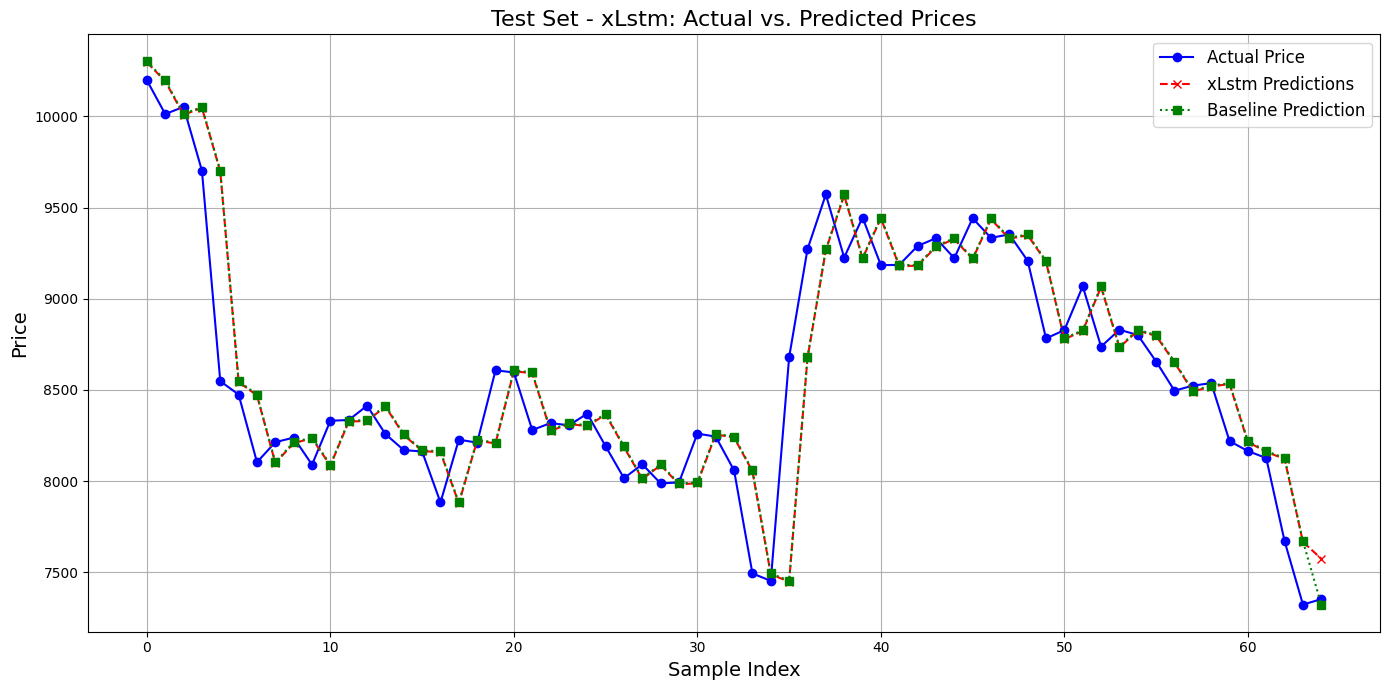

Test price plot saved to 'result_history/bit_sen_24_1_test_price_plot.png'


<ipython-input-4-02e1026c30d2>:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if delta > 0:
<ipython-input-4-02e1026c30d2>:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  rs = up / down if down != 0 else 0


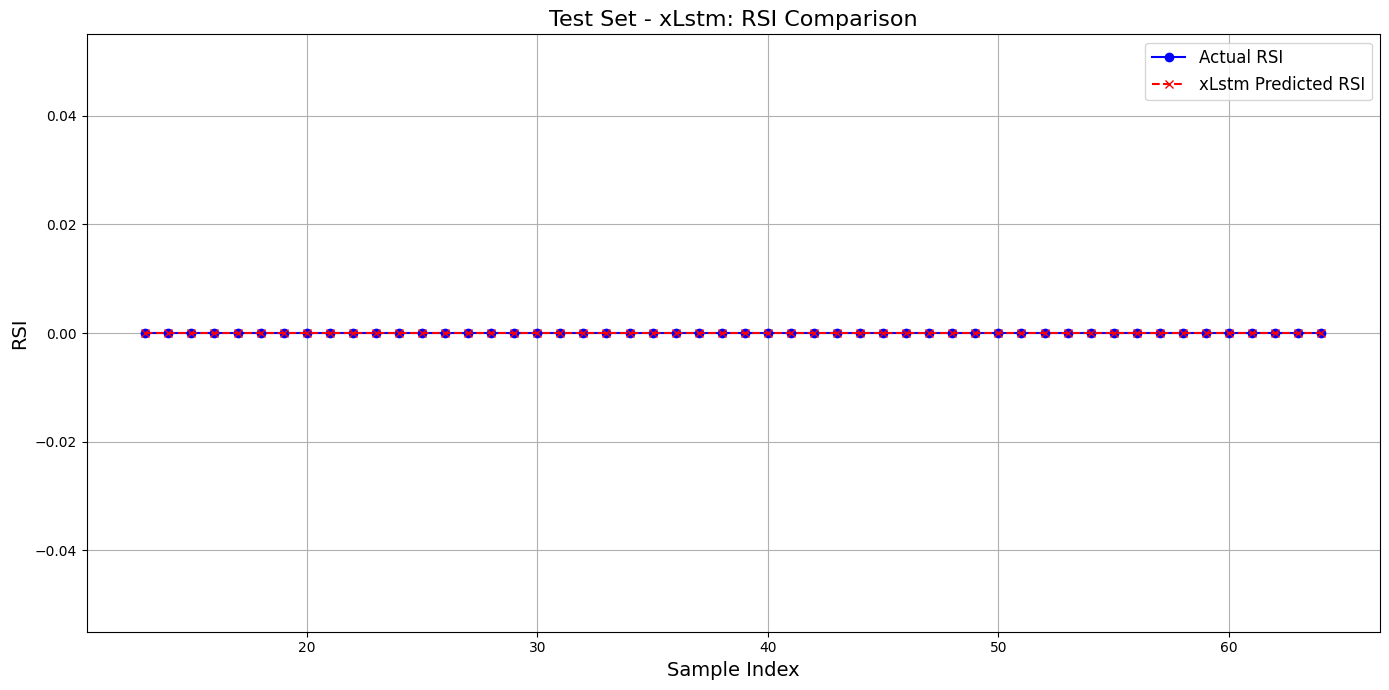

Test RSI comparison plot saved to 'result_history/bit_sen_24_1_test_rsi_plot.png'


/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


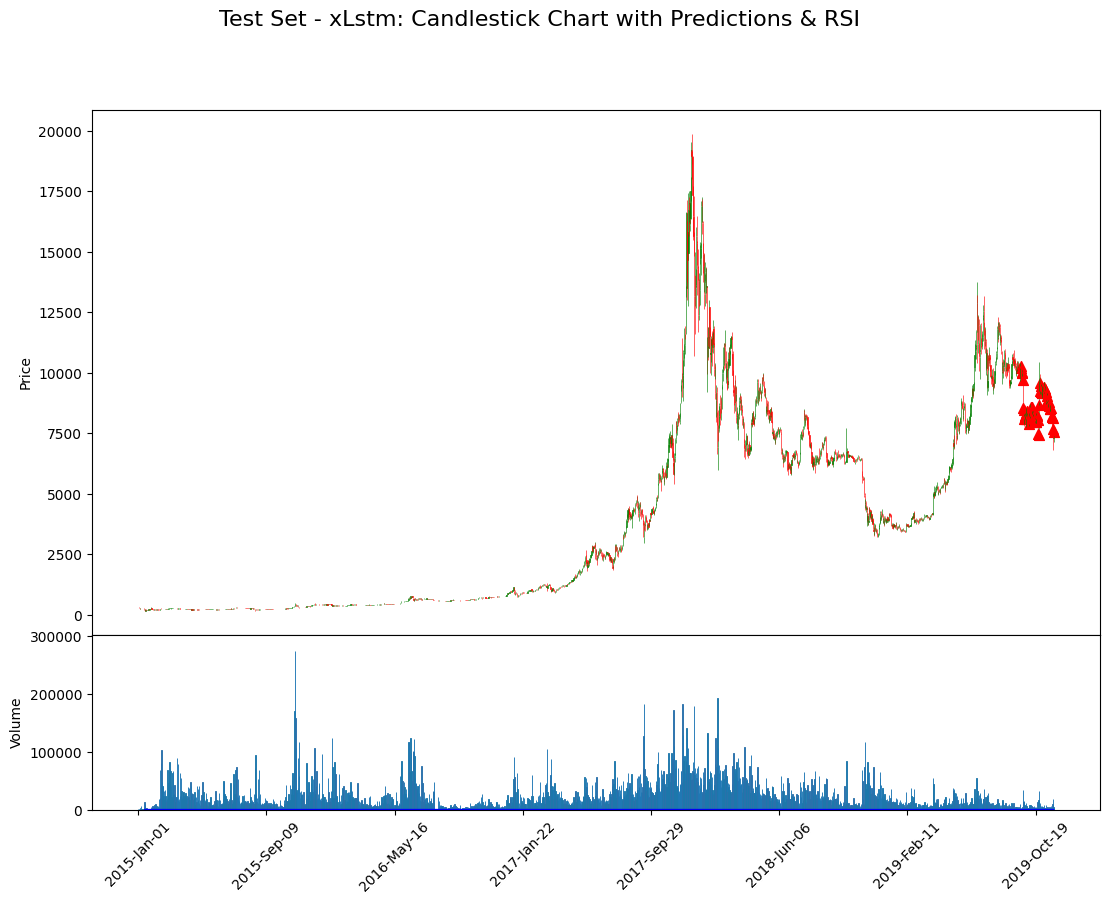

Test candlestick chart saved to 'result_history/bit_sen_24_1_candlestick.png'

Evaluation completed for 'bit_sen' with model 'xLstm' and forecast_history=24.
Metrics and plots appended to 'result_history/bit_sen_metrics.txt' and saved in 'result_history'


In [ ]:
# Plot: Actual vs. Predicted Prices (Test Set)
try:
    indices = np.arange(len(actuals))
    plt.figure(figsize=(14, 7))
    plt.plot(indices, actuals, label='Actual Price', marker='o', linestyle='-', color='blue')
    plt.plot(indices, test_predictions, label=f"{model_name} Predictions", marker='x', linestyle='--', color='red')
    if include_baseline:
        plt.plot(indices, baseline_predictions, label='Baseline Prediction', marker='s', linestyle=':', color='green')
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.title(f"Test Set - {model_name}: Actual vs. Predicted Prices", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    price_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_test_price_plot.png"
    price_plot_path = result_history_dir / price_plot_filename
    plt.savefig(price_plot_path)
    plt.show()
    plt.close()
    log_print(f"Test price plot saved to '{price_plot_path}'")
except Exception as e:
    log_print(f"Error during test price plotting: {e}")

# Plot: RSI Comparison (Test Set)
try:
    indices = np.arange(len(actuals))
    plt.figure(figsize=(14, 7))
    rsi_actual = compute_rsi(actuals, period=14)
    rsi_pred = compute_rsi(test_predictions, period=14)
    plt.plot(indices, rsi_actual, label='Actual RSI', marker='o', linestyle='-', color='blue')
    plt.plot(indices, rsi_pred, label=f"{model_name} Predicted RSI", marker='x', linestyle='--', color='red')
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('RSI', fontsize=14)
    plt.title(f"Test Set - {model_name}: RSI Comparison", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    rsi_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_test_rsi_plot.png"
    rsi_plot_path = result_history_dir / rsi_plot_filename
    plt.savefig(rsi_plot_path)
    plt.show()
    plt.close()
    log_print(f"Test RSI comparison plot saved to '{rsi_plot_path}'")
except Exception as e:
    log_print(f"Error during test RSI plotting: {e}")

# Test Candlestick Chart with Predictions & RSI
try:
    df_candle = df_raw.copy()
    df_candle[datetime_col] = pd.to_datetime(df_candle[datetime_col])
    df_candle = df_candle.sort_values(by=datetime_col)
    if 'Price' in df_candle.columns:
        df_candle.rename(columns={'Price': 'Close'}, inplace=True)
    if 'Vol.' in df_candle.columns:
        df_candle.rename(columns={'Vol.': 'Volume'}, inplace=True)
        df_candle['Volume'] = df_candle['Volume'].apply(
            lambda x: float(x.replace('K', '')) * 1000 if isinstance(x, str) and 'K' in x else float(x)
        )
    df_candle.set_index(datetime_col, inplace=True)
    rsi_values = compute_rsi(df_candle['Close'].values, period=14)
    df_candle['RSI'] = rsi_values
    # Use the Date column from test_df as the index for predictions
    test_index = pd.to_datetime(test_df[datetime_col])
    n_missing = forecast_history + forecast_horizon - 1
    pred_full = [np.nan] * n_missing + list(test_predictions.flatten())
    pred_full = pred_full[:len(test_index)]
    pred_series = pd.Series(pred_full, index=test_index)
    df_candle.loc[test_index, 'Predicted'] = pred_series
    apds = [
        mpf.make_addplot(df_candle['RSI'], panel=1, color='blue', ylabel='RSI'),
        mpf.make_addplot(df_candle['Predicted'], type='scatter', markersize=50, marker='^', color='red', panel=0)
    ]
    mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
    style = mpf.make_mpf_style(marketcolors=mc)
    volume_flag = True if 'Volume' in df_candle.columns else False
    fig, axlist = mpf.plot(df_candle, type='candle', style=style, volume=volume_flag,
                            addplot=apds, returnfig=True, figsize=(14, 10), panel_ratios=(3, 1))
    fig.suptitle(f"Test Set - {model_name}: Candlestick Chart with Predictions & RSI", fontsize=16)
    candle_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_candlestick.png"
    candle_plot_path = result_history_dir / candle_plot_filename
    fig.savefig(candle_plot_path)
    plt.show()
    plt.close(fig)
    log_print(f"Test candlestick chart saved to '{candle_plot_path}'")
except Exception as e:
    log_print(f"Error during test candlestick plotting: {e}")

log_print(f"\nEvaluation completed for '{csv_base}' with model '{model_name}' and forecast_history={forecast_history}.")
log_print(f"Metrics and plots appended to '{metrics_path}' and saved in '{result_history_dir}'")